# Churn analysis and prediction

**Description**

Customer churn is also known as customer turnover, or customer attrition, is the loss of clients or customers.

Telephone service companies, Internet service providers, pay TV companies, insurance firms, and alarm monitoring services, often use customer attrition analysis and customer attrition rates as one of their key business metrics because the cost of retaining an existing customer is far less than acquiring a new one. Companies from these sectors often have customer service branches which attempt to win back defecting clients, because recovered long-term customers can be worth much more to a company than newly recruited clients.

Predictive analytics use churn prediction models that predict customer churn by assessing their propensity of risk to churn. Since these models generate a small prioritized list of potential defectors, they are effective at focusing customer retention marketing programs on the subset of the customer base who are most vulnerable to churn.

Data is taken from https://www.kaggle.com/puja19/telcom-customer-churn

## Table of contents
0. [Loading data](#load)
1. [Exploratory analysis](#eda)
2. [Segmentation of churners](#segm)  
    2.1 [Dimensionality reduction](#dim)  
    2.2 [Clustering](#cluster)  
    2.3 [Analysis of segments](#analysis)
3. [Automating Churn Prediction](#ml)   
    3.1 [Skewness](#skew)  
    3.2 [Metrics, test-train splitting](#split)  
    3.3 [Logistic Regression](#logit)   
    3.4 [Naive Bayes](#bayes)  
    3.5 [Random Forest](#rf)  
    3.6 [XGBoost](#xg)
4. [Conclusions](#conc)

In [703]:
import os
import pandas as pd
import numpy as np
import pandas_profiling
import pylab
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.feature_selection import RFE

from category_encoders import CountEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix

from sklearn.cluster import KMeans, OPTICS, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import xgboost as xgb

## 0. Loading data <a id=load>

In [3]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [475]:
data = pd.read_csv(os.path.join('Telco-Customer-Churn.csv'))

In [5]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
# There are no missing values in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [476]:
# Correcting columns values
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0).astype('float64')

In [477]:
#Changing datatypes
data['TotalCharges'] = data['TotalCharges'].astype('float64')
data['SeniorCitizen'] = data['SeniorCitizen'].astype('category')

In [478]:
data['SeniorCitizen'].replace({0: 'No', 1:'Yes'}, inplace = True)

In [479]:
# Checking unique categorical values
categoricals = data.select_dtypes('object')
for i in categoricals.drop(['Churn', 'customerID'], axis = 1).columns:
        print('Unique values for variable %s: %s:' %(i, data[i].unique()))

Unique values for variable gender: ['Female' 'Male']:
Unique values for variable SeniorCitizen: ['No' 'Yes']:
Unique values for variable Partner: ['Yes' 'No']:
Unique values for variable Dependents: ['No' 'Yes']:
Unique values for variable PhoneService: ['No' 'Yes']:
Unique values for variable MultipleLines: ['No phone service' 'No' 'Yes']:
Unique values for variable InternetService: ['DSL' 'Fiber optic' 'No']:
Unique values for variable OnlineSecurity: ['No' 'Yes' 'No internet service']:
Unique values for variable OnlineBackup: ['Yes' 'No' 'No internet service']:
Unique values for variable DeviceProtection: ['No' 'Yes' 'No internet service']:
Unique values for variable TechSupport: ['No' 'Yes' 'No internet service']:
Unique values for variable StreamingTV: ['No' 'Yes' 'No internet service']:
Unique values for variable StreamingMovies: ['No' 'Yes' 'No internet service']:
Unique values for variable Contract: ['Month-to-month' 'One year' 'Two year']:
Unique values for variable PaperlessB

In [480]:
# Changing all the rest object types:
for i in categoricals:
    data[i]=data[i].astype('category')

In [13]:
#Number of uniques
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [14]:
#Final check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null category
gender              7043 non-null category
SeniorCitizen       7043 non-null category
Partner             7043 non-null category
Dependents          7043 non-null category
tenure              7043 non-null int64
PhoneService        7043 non-null category
MultipleLines       7043 non-null category
InternetService     7043 non-null category
OnlineSecurity      7043 non-null category
OnlineBackup        7043 non-null category
DeviceProtection    7043 non-null category
TechSupport         7043 non-null category
StreamingTV         7043 non-null category
StreamingMovies     7043 non-null category
Contract            7043 non-null category
PaperlessBilling    7043 non-null category
PaymentMethod       7043 non-null category
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null cate

# 1. Exploratory analysis <a id=eda>

Since our goal is to predict churn, first lets look at the ratio of customers who churned and who didn't:

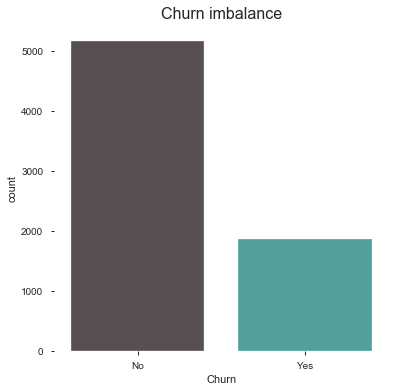

In [15]:
fig = plt.figure(figsize = (6,6))
sns.set_style('ticks')
a = sns.countplot(data['Churn'], palette = ['#594F4F', '#45ADA8'])
a.set_title('Churn imbalance', fontsize = 16);

In [314]:
print('Total class imbalance is: %s %% negative labels to %s %% positive ones. So 1 in 4 customers leaves us.' %(round(sum(data.Churn == 'Yes')*100/len(data.Churn),2), 
                                                round(sum(data.Churn == 'No')*100/len(data.Churn == 'Yes'),2)))

Total class imbalance is: 26.54 % negative labels to 73.46 % positive ones. So 1 in 4 customers leaves us.


Let's take a look at the factors that impact churn.

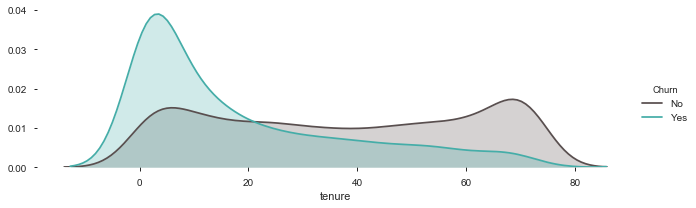

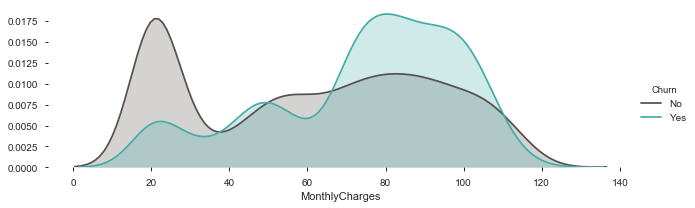

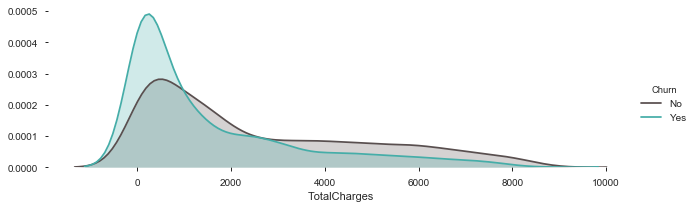

In [292]:
#Exporing individually numerical variables

for col in data.select_dtypes(np.number):
    g = sns.FacetGrid(data, hue="Churn", palette = ['#594F4F', '#45ADA8'], aspect = 3 )
    g.map(sns.kdeplot, col, shade = True)
    g.add_legend()

As we can see **numerical variables alone cannot capture the division between churn classes fully**, although the outliers tend to belong to one specific class, especially in Monthly Charges and tenure.

The majority of people who leave have very low Total Charges which may imply that **we're loosing a lot of customers on early stages**. There are a lot of **people who leave us because of high Monthly Charges** as well. A lot of **people who churn have low tenure**
.

Now, let's take a look at our categorical variables that emphasize the groups of our clients based on different attributes. For churn analysis it's crucial to consider two points:
- **The size of the targeted group**;
- **Propensity to churn within the group**. 


Knowing those features we can prioritize our marketing actions in order to achieve the best efficiency given certain cost on retaining the clients. If we find that customers belonging to a particular demographic or other group tend to churn more, we should first target the big groups with the higher propensity to churn and only then spend the rest of the marketing budget on small groups of our clients that leave us.

Now, **let's look into demographic aspect of our customer base**.

**Gender**

In [310]:
print('Total number of customers by gender:')
data['gender'].value_counts()

Total number of customers by gender:


Male      3555
Female    3488
Name: gender, dtype: int64

In [347]:
data.groupby(['Churn', 'gender'])['Churn'].count()

Churn  gender
No     Female    2549
       Male      2625
Yes    Female     939
       Male       930
Name: Churn, dtype: int64

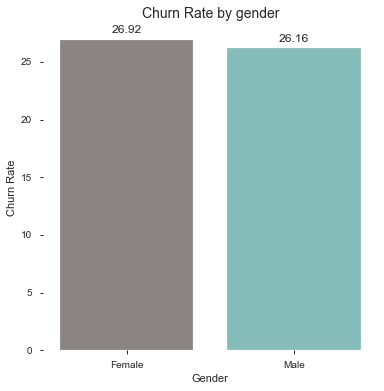

In [350]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(y = round(data[data['Churn'] == 'Yes']['gender'].value_counts()*100/data['gender'].value_counts(),2), 
                 x = data['gender'].unique(), palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by gender', fontsize = 14)
ax.set(xlabel='Gender', ylabel='Churn Rate')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 12);

**Churn doesn't seem to differ between gender**, neither in absolute, nor relative values(percentage of churned clients).

**Senior citizenship**

In [308]:
print('Total number of customers by seniority:')
data['SeniorCitizen'].value_counts()

Total number of customers by seniority:


No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

In [251]:
#Number of sinior clients:
print('There are %s %% senior clients in the database.' % round(sum(data['SeniorCitizen'] == 'Yes')*100/data.shape[0],2))

There are 16.21 % senior clients in the database.


In [346]:
data.groupby(['Churn', 'SeniorCitizen'])['Churn'].count()

Churn  SeniorCitizen
No     No               4508
       Yes               666
Yes    No               1393
       Yes               476
Name: Churn, dtype: int64

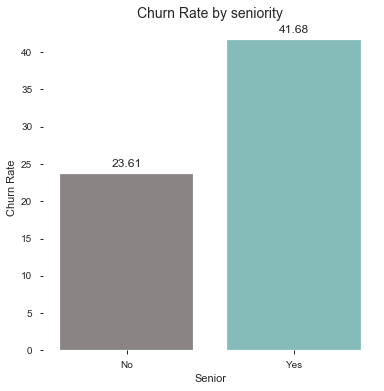

In [352]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(y = round(data[data['Churn'] == 'Yes']['SeniorCitizen'].value_counts()*100/data['SeniorCitizen'].value_counts(),2), 
                 x = data['SeniorCitizen'].value_counts().index.tolist(), palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by seniority', fontsize = 14)
ax.set(xlabel='Senior', ylabel='Churn Rate')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 12);

We can see that there are a **few senior customers in our business**. However, they seem to have a **significantly higher churn rate** (41.68% compared to only 23.61% amongst non senior citizens). But, given the fact that they comprise only 16% of all clients they should not be priority for marketing actions.

**Partner**

In [307]:
print('Total number of customers by partner:')
data['Partner'].value_counts()

Total number of customers by partner:


No     3641
Yes    3402
Name: Partner, dtype: int64

In [354]:
data.groupby(['Partner', 'Churn',])['Churn'].count()

Partner  Churn
No       No       2441
         Yes      1200
Yes      No       2733
         Yes       669
Name: Churn, dtype: int64

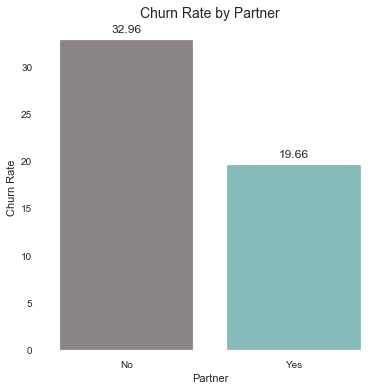

In [457]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(y = round(data[data['Churn'] == 'Yes']['Partner'].value_counts()*100/data['Partner'].value_counts(),2), 
                 x = data['Partner'].value_counts().index.tolist(), palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by Partner', fontsize = 14)
ax.set(xlabel='Partner', ylabel='Churn Rate')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 12);

**People without a partner seem to churn more than people without**. Given that it refers to more 50% of our customers, we should be careful about that.

**Dependents**

In [358]:
print('Total number of customers by Dependents:')
data['Dependents'].value_counts()

Total number of customers by Dependents:


No     4933
Yes    2110
Name: Dependents, dtype: int64

In [359]:
#Number of clients with dependents:
print('There are %s %% clients with dependents in the database.' % round(sum(data['Dependents'] == 'Yes')*100/data.shape[0],2))

There are 29.96 % clients with dependents in the database.


In [360]:
data.groupby(['Dependents', 'Churn',])['Churn'].count()

Dependents  Churn
No          No       3390
            Yes      1543
Yes         No       1784
            Yes       326
Name: Churn, dtype: int64

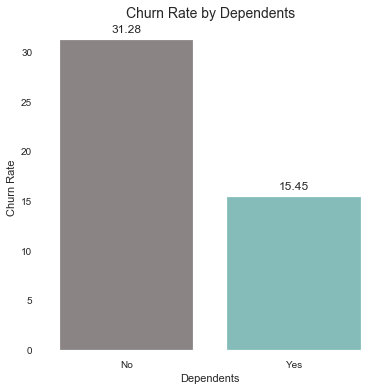

In [458]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(y = round(data[data['Churn'] == 'Yes']['Dependents'].value_counts()*100/data['Dependents'].value_counts(),2), 
                 x = data['Dependents'].value_counts().index.tolist(), palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by Dependents', fontsize = 14)
ax.set(xlabel='Dependents', ylabel='Churn Rate')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 12);

**People without dependents tend to churn twice as much as people with them**. The majority of our clients don't have any dependents, so their are in the risk group!

**Demographics in total**

Since gender didn't seem to have any impact let's combine all other factors together:

In [369]:
print('Total number of people in the group:')
data.groupby(['Dependents', 'Partner', "SeniorCitizen"])["SeniorCitizen"].count()

Total number of people in the group:


Dependents  Partner  SeniorCitizen
No          No       No               2719
                     Yes               561
            Yes      No               1163
                     Yes               490
Yes         No       No                353
                     Yes                 8
            Yes      No               1666
                     Yes                83
Name: SeniorCitizen, dtype: int64

In [421]:
# Churn rates by groups
round(data[data['Churn'] == 'Yes'].groupby(['Dependents', 'Partner', 
                "SeniorCitizen"])['Dependents'].count()*100/data.groupby(['Dependents', 'Partner', "SeniorCitizen"])['Dependents'].count(),2)

Dependents  Partner  SeniorCitizen
No          No       No               31.15
                     Yes              49.20
            Yes      No               20.81
                     Yes              36.33
Yes         No       No               21.25
                     Yes              25.00
            Yes      No               13.75
                     Yes              24.10
Name: Dependents, dtype: float64

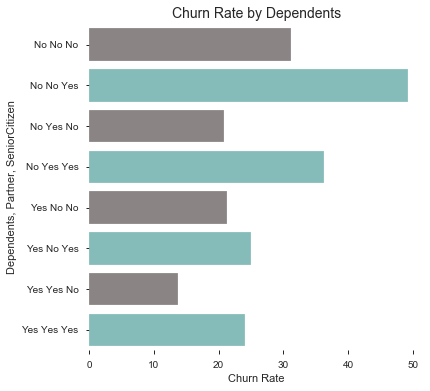

In [419]:
y_axis = ['No No No',
'No No Yes',
'No Yes No',
'No Yes Yes',
'Yes No No',
'Yes No Yes',
'Yes Yes No',
'Yes Yes Yes']

fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(x = round(data[data['Churn'] == 'Yes'].groupby(['Dependents', 'Partner', 
                "SeniorCitizen"])['Dependents'].count()*100/data.groupby(['Dependents', 'Partner', "SeniorCitizen"])['Dependents'].count(),2), 
                  y = y_axis,palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by Dependents', fontsize = 14)
ax.set(xlabel='Churn Rate', ylabel='Dependents, Partner, SeniorCitizen');

The **least churning group is young people with dependets and a partner** - 13.75%; **the most - seniors without dependents and partner** - 49.20%. However, this group accounts for only 561 people, which is only 8% of all customers, so it's not that fatal for business. The most concerning group is young people  without dependents and a partner who account for 38% of the clients and who's churn rate is 31.15%.

**Other categoricals**

Finally, let's take a look at people grouped by other attributes.

In [426]:
data.groupby(['PhoneService', 'Churn',])['Churn'].count()

PhoneService  Churn
No            No        512
              Yes       170
Yes           No       4662
              Yes      1699
Name: Churn, dtype: int64

In [428]:
data.groupby(['MultipleLines', 'Churn',])['Churn'].count()

MultipleLines     Churn
No                No       2541
                  Yes       849
No phone service  No        512
                  Yes       170
Yes               No       2121
                  Yes       850
Name: Churn, dtype: int64

In [429]:
data.groupby(['InternetService', 'Churn',])['Churn'].count()

InternetService  Churn
DSL              No       1962
                 Yes       459
Fiber optic      No       1799
                 Yes      1297
No               No       1413
                 Yes       113
Name: Churn, dtype: int64

In [430]:
data.groupby(['OnlineSecurity', 'Churn',])['Churn'].count()

OnlineSecurity       Churn
No                   No       2037
                     Yes      1461
No internet service  No       1413
                     Yes       113
Yes                  No       1724
                     Yes       295
Name: Churn, dtype: int64

In [431]:
data.groupby(['OnlineBackup', 'Churn',])['Churn'].count()

OnlineBackup         Churn
No                   No       1855
                     Yes      1233
No internet service  No       1413
                     Yes       113
Yes                  No       1906
                     Yes       523
Name: Churn, dtype: int64

In [432]:
data.groupby(['DeviceProtection', 'Churn',])['Churn'].count()

DeviceProtection     Churn
No                   No       1884
                     Yes      1211
No internet service  No       1413
                     Yes       113
Yes                  No       1877
                     Yes       545
Name: Churn, dtype: int64

In [435]:
data.groupby(['TechSupport', 'Churn',])['Churn'].count()

TechSupport          Churn
No                   No       2027
                     Yes      1446
No internet service  No       1413
                     Yes       113
Yes                  No       1734
                     Yes       310
Name: Churn, dtype: int64

In [436]:
data.groupby(['StreamingTV', 'Churn',])['Churn'].count()

StreamingTV          Churn
No                   No       1868
                     Yes       942
No internet service  No       1413
                     Yes       113
Yes                  No       1893
                     Yes       814
Name: Churn, dtype: int64

In [437]:
data.groupby(['StreamingMovies', 'Churn',])['Churn'].count()

StreamingMovies      Churn
No                   No       1847
                     Yes       938
No internet service  No       1413
                     Yes       113
Yes                  No       1914
                     Yes       818
Name: Churn, dtype: int64

In [438]:
data.groupby(['Contract', 'Churn',])['Churn'].count()

Contract        Churn
Month-to-month  No       2220
                Yes      1655
One year        No       1307
                Yes       166
Two year        No       1647
                Yes        48
Name: Churn, dtype: int64

In [439]:
data.groupby(['PaperlessBilling', 'Churn',])['Churn'].count()

PaperlessBilling  Churn
No                No       2403
                  Yes       469
Yes               No       2771
                  Yes      1400
Name: Churn, dtype: int64

In [464]:
data.groupby(['PaymentMethod', 'Churn',])['Churn'].count()

PaymentMethod              Churn
Bank transfer (automatic)  No       1286
                           Yes       258
Credit card (automatic)    No       1290
                           Yes       232
Electronic check           No       1294
                           Yes      1071
Mailed check               No       1304
                           Yes       308
Name: Churn, dtype: int64

Churn Rate by various attributes: 



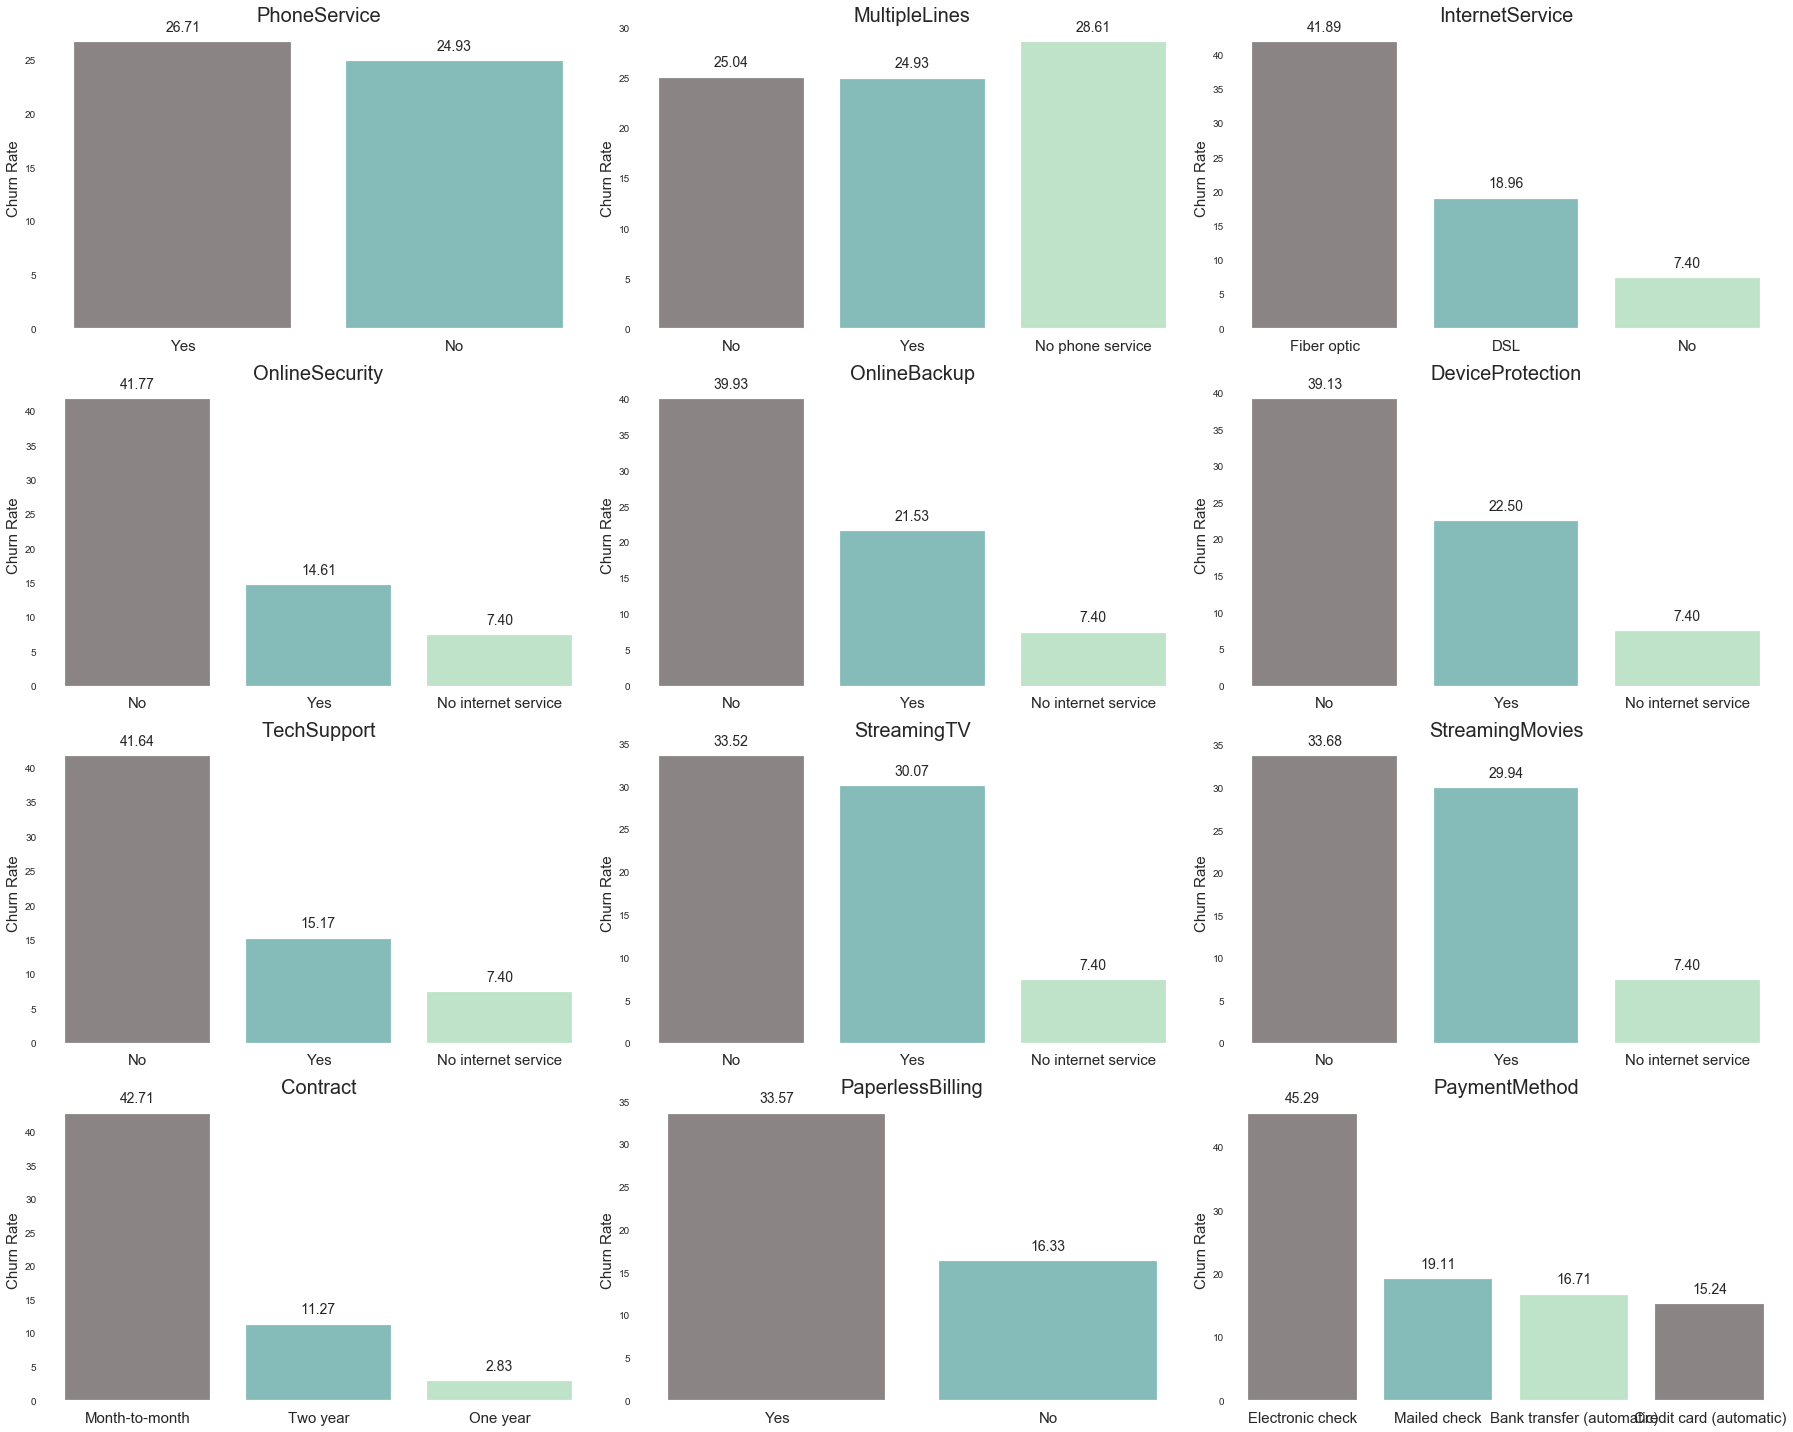

In [472]:
categ_columns = data.select_dtypes('category').columns.drop(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Churn'])

print('Churn Rate by various attributes: \n')

for i in enumerate(categ_columns):

    pylab.subplot(4,3,i[0]+1)
    ax = sns.barplot(y = round(data[data['Churn'] =='Yes'][i[1]].value_counts()*100/data[i[1]].value_counts(),2),x = data[i[1]].value_counts().index.tolist(), alpha=0.7,  palette = ['#594F4F', '#45ADA8', '#9DE0AD'])
    plt.gcf().set_size_inches(25, 20)
    plt.ylabel('Churn Rate', fontsize = 15)
    ax.set_title(i[1], fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.tight_layout()
    # Adding annotations
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', xytext = (0, 15), textcoords = 'offset points', fontsize = 14)

All the groups except from those based on PhoneService and MultipleLines seem to differ in their churn rates.
For example,  `InternetServices` might be a good predictor of churn - there is a clear separation between churn rates among different categories, with **the least churn being observed in clients with no internet service and the highest - with Fiber Optic**. There are **a lot of churners among people with no Online Security, no Device Protection, no Tech Support and no Online Backup.** The probability to **churn increases more than twice if the person is paying via electronic check**.The same is true if the person has a month - to month contract, which makes sense since those customers are less likely to be commit to us meaning they aren't sure about our services. There's little we can do about it, only work towards establishing long term relashionship with the customer.

Two top churn factors are `Contract` and `Payment Method` but as a company we can't really influence that. However, we can see that almost half of clients with Fiber internet leave us - this is **a clear indication that if we are the providers of Fiber service is doesn't work well**. Moreover, we **can see that customers who purchase complementary services like Online backup and security, Tech support, Device protection seem to churn way less** - it might infer that those services are of good quality and c**ross-sells might be used as way to retain clients**.

We can see that 30% of people who use Streaming services also churn. It is interesting to see whether those are mainly people with DSL connection or Fiber since the latter provides better speed. If that is true we could say that streaming customers might leave us because of poor Fiber internet.

In [442]:
# Total users of streaming services
data[(data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')]['InternetService'].value_counts()

Fiber optic    2191
DSL            1308
No                0
Name: InternetService, dtype: int64

In [478]:
# Churn rate among all streaming users
print('Churn rate among all streaming users: %s %% - higher than overall churn by 4 percentage points' %round(sum(((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')) & (data['Churn'] == 
                        'Yes'))*100/sum((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 
                        'Yes')), 2))
print('Total number of streaming users: %s, which is %s %% of all customers' %(sum((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')), 
                            round(sum((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes'))*100/data.shape[0],2)))

Churn rate among all streaming users: 30.32 % - higher than overall churn by 4 percentage points
Total number of streaming users: 3499, which is 49.68 % of all customers


In [451]:
# Churn rate among streaming users
round(data[((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')) & (data['Churn'] == 
                        'Yes')]['InternetService'].value_counts()*100/data[(data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 
                        'Yes')]['InternetService'].value_counts(), 2)

Fiber optic    39.94
DSL            14.22
No               NaN
Name: InternetService, dtype: float64

Indeed, about half of our streaming customers do use Fiber connection which seems to be poor. So it seems that **our streaming customers are churning because of speed of Fiber internet**. There are 49% of clients who use streaming services with us, so working on the quality of Fiber connection might be a good way to retain considerable number of clients.

Speaking of **complementary services**, let's look whether people tend to buy services in bundles, i.e. StreamingTV + StreamingMovies, OnlineSecurity + OnlineBackup.

In [141]:
data.groupby(['StreamingTV', 'StreamingMovies'])['StreamingMovies'].count()

StreamingTV          StreamingMovies    
No                   No                     2018
                     Yes                     792
No internet service  No internet service    1526
Yes                  No                      767
                     Yes                    1940
Name: StreamingMovies, dtype: int64

In [138]:
data.groupby(['OnlineSecurity', 'OnlineBackup'])['OnlineBackup'].count()

OnlineSecurity       OnlineBackup       
No                   No                     2195
                     Yes                    1303
No internet service  No internet service    1526
Yes                  No                      893
                     Yes                    1126
Name: OnlineBackup, dtype: int64

**People who own one Streaming Service tend to own another, however, people who have online security not necessarily have online backup**. Given that other complementary services seem to be good as well, we might increase loyalty by offering the clients those online services that they still don't have.

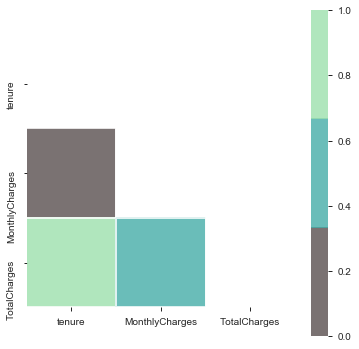

In [480]:
# Checking correlation between numericals
# Correlation of crimes of different types
corr_df = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

fig, ax = plt.subplots(figsize = (6, 6))
sns.heatmap(corr_df, cmap = ['#594F4F', '#45ADA8', '#9DE0AD'], vmin=0, vmax=1, linewidths=.3, square = True, mask = mask, alpha = 0.8)

#Adjusting bottom and top rows
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

Some of the numerics are correlated - we will have to check the performance of the ML model without them or with PCA.

## 2. Segmentation of customers who churned <a id=segm>

**Customer segmentation** may give insights into what makes certain customers similar, which in turn **may help to shape more effective marketing strategies**. It's important to realise that segmentation is highly dependent on underlying business task. 

Since we are interested in those who churn, let's subset our dataset for only those people to gain other insights into those customers' characteristics.

The **goal of the analysis is to determine sizable and actionable groups among people who churn**. This will allow us to prioritise several clusters depending on our marketing budget and come up with clear insights into the main turn-offs of each cluster.

**Technical note**:

There are several common algorithms used for clustering, the most popular are K-means, DBSCAN or Optics and Agglomerative Clustering. They have different hyperparameters and vary in how they determine clusters. All of them calculate clusters based on distance measures, thus it is extremely important to scale the dataset not to give false importance to 

#### K - means clustering

K-means bases it's clusters on **finding k cluster centres** (the number k has to be specified manually beforehand) **as the mean of the data points that belong to these clusters**. Therefore, it is highly **dependent on the initial number of clusters**, as well as **initial start point of the centroids**, which is chosen randomly every time. 

#### Density based algorithms

Those base their clusters on density estimations as indicated dy their name.

The most well known density based algorithm is **DBSCAN (Density-based spatial clustering of applications with noise)**. It locates regions of high density that are separated from one another by regions of low density. DBSCAN is ideal to deal with large spatial databases since it **can detect noise and outliers**.

Main hyperparameters in DBSCAN are *Radius Eps (ϵ)* which specifies how close points should be to each other to be considered a part of a cluster and *minimum number of points (MinPts)* which have to be within this radius to form a dense region. **Main drawback of DBSCAN is that if the database has data points that form clusters of varying density, then DBSCAN will fail to cluster the data points well**, since the clustering depends on ϵ and MinPts parameter, they cannot be chosen separately for all clusters.

Another density based algorithm is **Optics**, it is similar to DBSCAN but can deal with varying densities, as well as ir requires very little parameter tuning.

#### Hierarchical clustering

There are two ways of hierarchical clustering:
- **Agglomerative clustering** (Bottom-up approach): Each sample is treated as a single cluster and then successively merge (or agglomerate) pairs of clusters until all clusters have been merged into a single cluster.
- **Divisive clustering** (top-down): A single cluster of all the samples is portioned recursively into two least similar clusters until there is one cluster for each observation. The divisive clustering algorithm is exactly the reverse of Agglomerative clustering.

Hierarchical algorithms are more cumbersome and do not scale well to large datasets.

### 2.1 Dimensionality reduction <a id=dim>

To be able to perform a better clustering, it's might be beneficial to reduce the number of dimensions(variables) in our dataset using one of the dimensionality reduction techniques, for example, PCA or TSNE. The goal in applying those techniques is to **detect certain shapes which might indicate separate clusters**.  

In [ ]:
pca_pipe = Pipeline([('count_encoder', CountEncoder()), 
                    ('scaler', StandardScaler())
                    ])
data_prep = pca_pipe.fit_transform(data[data['Churn'] =='Yes'].drop('Churn', axis = 1))

pca = PCA()
data_pca = pd.DataFrame(pca.fit_transform(data_prep), columns=["PC{}".format(i) for i in range(pca.n_components_)])

In [251]:
# Cumulative explained variance ratio
pca.explained_variance_ratio_.cumsum()

array([0.24005449, 0.41844871, 0.54994699, 0.61800808, 0.67380116,
       0.72401681, 0.76963044, 0.81059368, 0.84405606, 0.87457507,
       0.90278754, 0.92871497, 0.95323436, 0.97372345, 0.99118756,
       0.99576799, 0.99845884, 0.99996861, 0.99999998, 1.        ,
       1.        ])

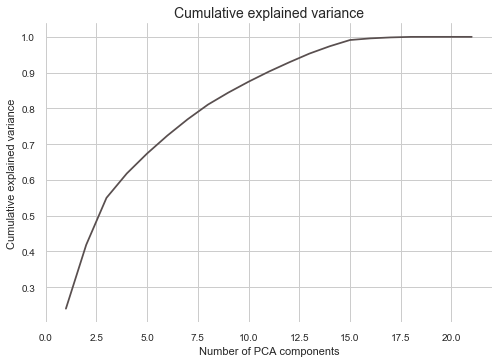

In [256]:
sns.set_style('whitegrid')
sns.lineplot(x = range(1,22), y= pca.explained_variance_ratio_.cumsum(), color = '#594F4F')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance', fontsize = 14);

We can see that the optimal cutoff for number of components is either 3 or 15. We will capture either 54.9% or 99.1% of information respectively.

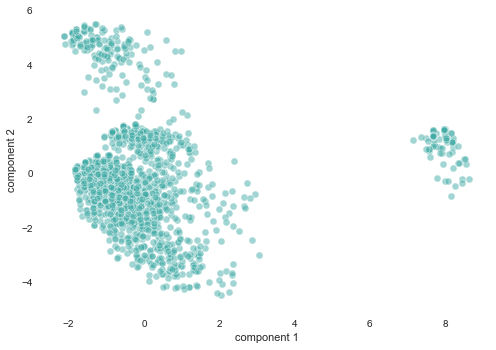

In [261]:
#Plotting the first two components
sns.set_style('white')
sns.scatterplot(data_pca.iloc[:, 0], data_pca.iloc[:, 1], alpha=0.5, color = '#45ADA8')
plt.xlabel('component 1')
plt.ylabel('component 2');

It's interesting to see that apparently we do have distinguishible groups of customers, looks like there might be 3 or 4 clusters here.

### 2.2 Clustering <a id=cluster>

**K-means**

The most well known way to determine the number of clusters (k) is *elbow method*. Basically it means that we calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish.
- The Squared Error for each point is the square of the distance of the point from its representation i.e. its predicted cluster center. 
- The WSS score is the sum of these Squared Errors for all the points.
- Any distance metric like the Euclidean Distance or the Manhattan Distance can be used.

In [269]:
# Dropping last component since it doesn't give us any new information
data_pca = data_pca.drop('PC20', axis = 1)

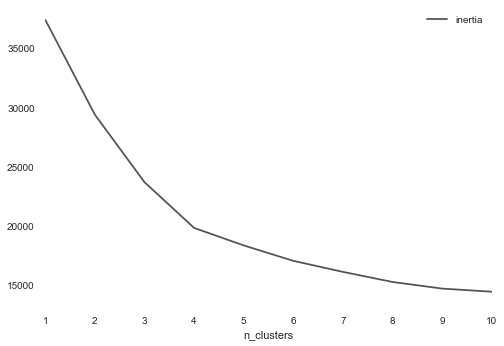

In [270]:
n_clusters = [1,2,3,4,5,6,7,8,9,10]
inertia = []

for num in n_clusters:
    kmeans_model = KMeans(n_clusters=num, n_jobs=-1).fit(data_pca)
    wss = kmeans_model.inertia_
    inertia.append(wss)
    
pd.DataFrame({'n_clusters':n_clusters, 'inertia': inertia}).plot(x='n_clusters', y='inertia', color = '#594F4F');

The best number of clusters is either 2,3 or 4.

In [297]:
#Fitting and getting silhoette score that describes
km = KMeans(n_clusters=2)
cluster = km.fit(data_pca)
cluster_labels = cluster.labels_
silhouette_avg = silhouette_score(data_pca, cluster_labels)
print("The average silhouette_score with 2 clusters is :", round(silhouette_avg, 3))

The average silhouette_score with 2 clusters is : 0.462


In [272]:
# Checking how many observations fall into either of labels - from the business perspective the groups should be sizable enough.
unique, counts = np.unique(cluster_labels, return_counts=True)
pd.DataFrame({'Cluster': unique, 'Percent of observations in the group': (counts*100/data_pca.shape[0]).round(2)})

,Cluster,Percent of observations in the group
0,0,6.05
1,1,93.95


In [273]:
#Fitting and getting silhoette score that describes
km = KMeans(n_clusters=3)
cluster = km.fit(data_pca)
cluster_labels = cluster.labels_
silhouette_avg = silhouette_score(data_pca, cluster_labels)
print("The average silhouette_score with 2 clusters is :", round(silhouette_avg, 3))

The average silhouette_score with 2 clusters is : 0.387


In [274]:
# Checking how many observations fall into either of labels - from the business perspective the groups should be sizable enough.
unique, counts = np.unique(cluster_labels, return_counts=True)
pd.DataFrame({'Cluster': unique, 'Percent of observations in the group': (counts*100/data_pca.shape[0]).round(2)})

,Cluster,Percent of observations in the group
0,0,6.05
1,1,84.86
2,2,9.10


In [275]:
#Fitting and getting silhoette score that describes
km = KMeans(n_clusters=4)
cluster = km.fit(data_pca)
cluster_labels = cluster.labels_
silhouette_avg = silhouette_score(data_pca, cluster_labels)
print("The average silhouette_score with 4 clusters is :", round(silhouette_avg, 3))

The average silhouette_score with 4 clusters is : 0.284


In [276]:
# Checking how many observations fall into either of labels - from the business perspective the groups should be sizable enough.
unique, counts = np.unique(cluster_labels, return_counts=True)
pd.DataFrame({'Cluster': unique, 'Percent of observations in the group': (counts*100/data_pca.shape[0]).round(2)})

,Cluster,Percent of observations in the group
0,0,9.10
1,1,64.37
2,2,6.05
3,3,20.49


With 2 clusters out silhoette score is better. However, with only 2 clusters one group seems to be the majority of observations which might not be desirable. At the same time, the minority group has more than 5% of observations which is sizable enough.

Let's check other clustering methods.


**OPTICS**

In [283]:
op = OPTICS(min_samples=90, max_eps=30)
cluster2 = op.fit(data_pca)
print("Num. clusters: {}".format(len(set(cluster2.labels_))))

Num. clusters: 3


In [284]:
silhouette_avg = silhouette_score(data_pca, cluster2.labels_)
print("The average silhouette_score is :", round(silhouette_avg, 3))

The average silhouette_score is : 0.387


In [285]:
# Checking how many observations fall into either of labels - from the business perspective the groups should be sizable enough.
unique, counts = np.unique(cluster2.labels_, return_counts=True)
pd.DataFrame({'Cluster': unique, 'Percent of observations in the group': (counts*100/data_pca.shape[0]).round(2)})

,Cluster,Percent of observations in the group
0,0,84.86
1,1,9.10
2,2,6.05


Looks good both from the silhoette perspective and number of clusters.

**Agglomerative Clustering**

In [286]:
ag = AgglomerativeClustering(n_clusters=2)
cluster3 = ag.fit(data_pca)
silhouette_avg = silhouette_score(data_pca, cluster3.labels_)
print("The average silhouette_score is :", round(silhouette_avg, 3))

The average silhouette_score is : 0.462


In [287]:
# Checking how many observations fall into either of labels - from the business perspective the groups should be sizable enough.
unique, counts = np.unique(cluster3.labels_, return_counts=True)
pd.DataFrame({'Cluster': unique, 'Percent of observations in the group': (counts*100/data_pca.shape[0]).round(2)})

,Cluster,Percent of observations in the group
0,0,93.95
1,1,6.05


Let's stick with OPTICS clustering - it gives a good balance between number of clusters and silhoette score.

### 2.3 Analysis of segments <a id=analysis>

In [483]:
labeled_data = data[data['Churn'] =='Yes'].drop('Churn', axis = 1)
labeled_data['cluster'] = cluster2.labels_

In [485]:
# Let's compute the mean of each variable for those who didn't churn and see how the clusters differs in their statistics
var_means = data[data['Churn'] =='No'].drop('Churn', axis = 1).mean()
var_means

tenure              37.569965
MonthlyCharges      61.265124
TotalCharges      2549.911442
dtype: float64

In [416]:
labeled_data.groupby("cluster").mean()

,tenure,MonthlyCharges,TotalCharges
cluster,,,
0,18.902900,82.250000,1719.085120
1,15.835294,37.533824,687.087941
2,8.238938,20.368142,173.919912


In [417]:
ratio_vs_mean = labeled_data.groupby("cluster").mean() / var_means

We visualize the ratio of each cluster's mean vs. the global mean of those who do not churn for each variable. We color-code the values to make them easier to uniderstand.

- Value < 0.5 - Blue
- 0.5 <= value < 1 - Brown
- Value >=1 - Red

In [418]:
def color_scheme(val):
    color =  '#594F4F'
    if val < 0.5:
        color = '#45ADA8'
    elif val >= 1:
        color = '#E8175D'
    return 'color: %s' % color
 
numericals = ratio_vs_mean.style.applymap(color_scheme)
numericals

,tenure,MonthlyCharges,TotalCharges
cluster,,,
0,0.503139,1.34253,0.674174
1,0.421488,0.612646,0.269456
2,0.219296,0.332459,0.0682063


We can see that **Cluster_0 is characterised by higher tenure, Total Charges and extremely high Monthly Charges**. These people represent 85% of the churners.

**Cluster_1 likely represents people who leave us in the meduim run** given their Total Charges being only 27% of the average of those who don't churn. At the same time those customers tend to have lower Monthly Charges and a lower tenure. There are 9% of those churners.

**Cluster_2 is probably people who didn't stay with us long since their Total Charges are only 7% of the average of those who don't churn**. Those are quick churners (6%).

In [364]:
#Adding modes of categorical variables
cluster_0 = labeled_data[labeled_data['cluster'] == 0].drop('customerID', axis = 1).select_dtypes('category').mode(dropna=True)
cluster_1 = labeled_data[labeled_data['cluster'] == 1].drop('customerID', axis = 1).select_dtypes('category').mode(dropna=True)
cluster_2 = labeled_data[labeled_data['cluster'] == 2].drop('customerID', axis = 1).select_dtypes('category').mode(dropna=True)

In [384]:
clusters_together = pd.concat([cluster_0,cluster_1, cluster_2 ], axis = 0)
clusters_together['cluster'] = [0,1,2]
clusters_together.set_index('cluster', inplace = True)

In [395]:
full_table = ratio_vs_mean.merge(clusters_together, left_on = ratio_vs_mean.index, right_on = clusters_together.index)
full_table.rename(columns = {'key_0':'cluster'}, inplace = True)
full_table.set_index('cluster', inplace=True)

In [401]:
#Looking at the full table with categorical descriptoprs
full_table.head()

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
cluster,,,,,,,,,,,,,,,,,,,
0,1.05138,1.104897,1.122268,Female,No,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
1,0.88076,0.504207,0.448551,Male,No,No,No,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
2,0.45825,0.273613,0.113540,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check


In [419]:
# The mode of those customer's who don't churn
data[data['Churn'] =='No'].drop(['cluster', 'Churn', 'customerID'], axis = 1).select_dtypes('category').mode(dropna=True)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Male,No,Yes,No,Yes,No,DSL,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Mailed check


Summing it up:  
**Cluster_0**:
- Represents 85% of churners;
- Consists mostly of females in contrast with other two clusters;
- Subscribed to Multiple Lines and Fiber Optic internet;  
- Higher tenure, Montly and Total Charges

**Cluster_1**:
- Represents 9% of churners;
- Don't have phone service;
- Have DSL internet connection;  
- Lower Total Charges, medium Monthly Charges, almost average tenure

**Cluster_2**:
- Represent 6% of churners;
- Don't have Multiple Lines;
- Don't have internet service;
- Pay with mailed check; 
- Only use our Phone Services;
- Extremely low Total, Montly Charges and tenure

Churners don't really seem to differentiate between each other based on Streaming services, Device Pritection, Online Backup, Online Security, Partner, Seniority and Dependents.

**Recommendations:**  
**Cluster_0**:
- Look into Fiber connection, the speed or connection are not good;
- Monthly charges seem to be 30% higher than the average of those customers who don't churn - either decrease monthy charges or provide better quality services;

**Cluster_1**:
- Push Streaming services

**Cluster_2**:
- Try to sell our internet service, push DSL one.

**All clusters:**
- Push Online backup, security, device protection services.

## 3. Automating Churn Prediction <a id=ml>

Typically we would use Machine Learning model that would determine who are the clients who are gonna churn and then use clustering on the customers who are predicted to churn, so that we can target them with appropriate marketing actions and change their decision to leave in time.

### 3.1 Checking Skewness <a id=skew>

Before proceeding to machine learning let's take a look at skewness of numerical variables.

In [486]:
from scipy.stats import skew

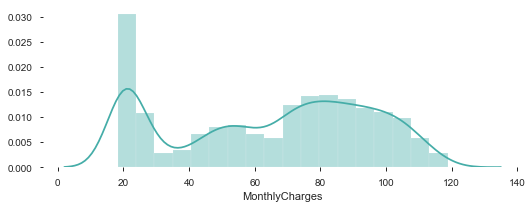

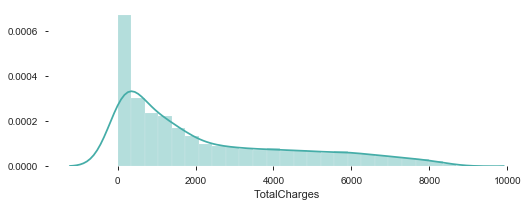

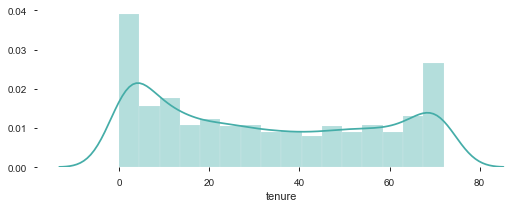

In [481]:
for i in ['MonthlyCharges', 'TotalCharges', 'tenure']:
    a = sns.FacetGrid(data[['MonthlyCharges', 'TotalCharges', 'tenure']], aspect = 2.5, palette = '#45ADA8')
    a.map(sns.distplot,i,color = '#45ADA8')
    plt.show()

The variables look skewed, let's calculate it:

In [223]:
print('Skewness of MonthlyCharges %s' %skew(data['MonthlyCharges']))
print('Skewness of TotalCharges %s' %skew(data['TotalCharges']))
print('Skewness of Tenure %s' %skew(data['tenure']))

Skewness of MonthlyCharges -0.2204774644391769
Skewness of TotalCharges 0.9630294954586066
Skewness of Tenure 0.2394887299846216


In [235]:
# Dealing with TotalCharges
print('Skewness of TotalCharges, sqrt %s' %skew(np.sqrt(data['TotalCharges'])))

Skewness of TotalCharges, sqrt 0.3076546076982302


The square root seems to improve the situation, we'll leave all other variables as they are.

In [487]:
data['TotalCharges'] = np.sqrt(data['TotalCharges'])

### 3.2 Metrics, test-train splitting <a id=split>

Before diving into the Machine Learning it's important to discuss metrics.

Typical metrics would be accuracy, f1 score, precision, recall and roc auc. However, given the imbalanced dataset accuracy is not a suitable metric. Here **we will optimise for f1 score** which balances precision and recall.

Given churn problem, our **False Positives** (people who the model predicted to be churners but in reality are not) **represent money lost on unnecessary marketing campaigns** and our **False Negatives** (people who the model predicted aren't churners but in reality they did churn) **represent people whom we could've retained had we targeted market campaign on them as well**.

However, the main task is to correctly determine churners.

In any way, it's crucial to monitor the changes in the confusion matrix, so that we choose the model most suitable for the business.

In [650]:
# Train-test splitting - given imbalanced dataset it's preferable to take a stratified split

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data, data["Churn"]):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]

class_to_num = {'No':0, 'Yes':1}   
X_train = strat_train.drop(["Churn", "customerID"], axis = 1)
y_train = strat_train.Churn.replace(class_to_num)

X_test = strat_test.drop(["Churn", "customerID"], axis = 1)
y_test = strat_test.Churn.replace(class_to_num)

In [651]:
# Setting an ML pipeline - it's desirable to experiment with categorical encoders (possible options are LabelEncoder, CountEncoder, OneHotEncoder, 
# as wel as scalers - MinMaxScaler, StandardScaler)

transformation_pipeline = Pipeline([('count_encoder', CountEncoder()), 
                    ('scaler', StandardScaler())
                    ])

X_train_prep = transformation_pipeline.fit_transform(X_train)
X_test_prep = transformation_pipeline.fit_transform(X_test) 

### 3.3 Logistic Regression <a id=logit>

In [616]:
# Checking which columns to eliminate with RFE
rfe = RFE(LogisticRegression(), step = 1)
rfe = rfe.fit(X_train_prep, y_train)
print('Ranking of features:', rfe.ranking_)
print('Features to keep:', strat_train.drop(['Churn', "customerID"], axis = 1).columns[rfe.support_].tolist())

Ranking of features: [10  8 11  6  9  3  1  1  1  2  7  1  1  1  1  4  5  1  1]
Features to keep: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'MonthlyCharges', 'TotalCharges']


Let's check P-value of those columns suggested - if the P-value is less than 0.05, then we will eliminate the feature.

In [618]:
columns_to_keep = strat_train.drop(['Churn', "customerID"], axis = 1).columns[rfe.support_].tolist()
train = pd.DataFrame(data = X_train_prep, columns = X_train.columns, index = y_train.index)[columns_to_keep]

# Checking P-values - P-values less than 0.05 say that the feature is not important in predicting Churn
from statsmodels.discrete.discrete_model import Logit

logit_model = Logit(y_train, train)
logit_results = logit_model.fit()
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.570260
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5625
Method:                           MLE   Df Model:                            8
Date:                Tue, 24 Mar 2020   Pseudo R-squ.:                 0.01438
Time:                        16:44:26   Log-Likelihood:                -3212.8
converged:                       True   LL-Null:                       -3259.7
Covariance Type:            nonrobust   LLR p-value:                 7.944e-17
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
MultipleLines      -0.2217      0.039     -5.672      0.000      -0.298      -0.145
InternetServic

We can see that only **Streaming Services seems to be unimportant**, let's remove them. This goes together with previous analysis we did - we saw that the churn rates do not seem to differ between churners and not.

In [667]:
# Train-test splitting again, to remove the columns- to keep only suggested columns

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data, data["Churn"]):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]

class_to_num = {'No':0, 'Yes':1}   
X_train = strat_train[['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'TechSupport',
 'Contract',
 'MonthlyCharges',
 'TotalCharges']]
y_train = strat_train.Churn.replace(class_to_num)

X_test = strat_test[['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'TechSupport',
 'Contract',
 'MonthlyCharges',
 'TotalCharges']]
y_test = strat_test.Churn.replace(class_to_num)

transformation_pipeline = Pipeline([('count_encoder', CountEncoder()), 
                    ('scaler', StandardScaler())
                    ])

X_train_prep = transformation_pipeline.fit_transform(X_train)
X_test_prep = transformation_pipeline.fit_transform(X_test) 

In [624]:
# Initialising Grid Search
logit_cl = LogisticRegression()

params_grid =  {
     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
     'C': [ 0.001, 0.01, 0.1, 0.0001],
     'class_weight': ['balanced', 'none'],
     'random_state': [27, 42, 901],
     'solver': ['lbfgs', 'liblinear', 'saga']
    
}

grid_logit = GridSearchCV(logit_cl, cv = StratifiedKFold(5), param_grid = params_grid, n_jobs = -1, verbose = 10, 
                      scoring = 'f1').fit(X_train_prep, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1948s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0896s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1148s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed: 

In [625]:
#Best params
grid_logit.best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'penalty': 'none',
 'random_state': 27,
 'solver': 'lbfgs'}

In [668]:
y_test_pred = grid_logit.best_estimator_.predict(X_test_prep)
y_train_pred = grid_logit.best_estimator_.predict(X_train_prep)

print('Train performance on Logistic Regression:', f1_score(y_train_pred, y_train))
print('Test performance on Logistic Regression: %s \n'% f1_score(y_test, y_test_pred))
print('Precision: %s'% precision_score(y_test, y_test_pred))
print('Recall: %s'% recall_score(y_test, y_test_pred))

target_class = ['didn\'t churn', 'churn']
print('\n', classification_report(y_test, y_test_pred, target_names = target_class))
print('Confusion matrix, optimised for F1 score \n')
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=['pred_didn\'t churn', 'pred_churn'], index=['didn\'t churn', 'churn']))

Train performance on Logistic Regression: 0.619368203003625
Test performance on Logistic Regression: 0.6059365404298874 

Precision: 0.49087893864013266
Recall: 0.7914438502673797

               precision    recall  f1-score   support

didn't churn       0.90      0.70      0.79      1035
       churn       0.49      0.79      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.79      0.73      0.74      1409

Confusion matrix, optimised for F1 score 

              pred_didn't churn  pred_churn
didn't churn                728         307
churn                        78         296


In [652]:
# Predicted churn rate - we are way overestimating our churn rate
(307+296)/(728+78+307+296)

0.42796309439318664

### 3.4 Naive Bayes <a id=bayes>

In [687]:
# Train-test splitting - taking all the features again

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data, data["Churn"]):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]

class_to_num = {'No':0, 'Yes':1}   
X_train = strat_train.drop(["Churn", "customerID"], axis = 1)
y_train = strat_train.Churn.replace(class_to_num)

X_test = strat_test.drop(["Churn", "customerID"], axis = 1)
y_test = strat_test.Churn.replace(class_to_num)

# Setting an ML pipeline - it's desirable to experiment with categorical encoders (possible options are LabelEncoder, CountEncoder, OneHotEncoder, 
# as wel as scalers - MinMaxScaler, StandardScaler)

transformation_pipeline = Pipeline([('count_encoder', CountEncoder()), 
                    ('scaler', StandardScaler())
                    ])

X_train_prep = transformation_pipeline.fit_transform(X_train)
X_test_prep = transformation_pipeline.fit_transform(X_test) 

In [661]:
nb_cl = GaussianNB().fit(X_train_prep, y_train)

In [665]:
y_test_pred = nb_cl.predict(X_test_prep)
y_train_pred = nb_cl.predict(X_train_prep)

print('Train performance on Naive Bayes:', f1_score(y_train_pred, y_train))
print('Test performance on Naive Bayes: %s \n'% f1_score(y_test, y_test_pred))
print('Precision: %s'% precision_score(y_test, y_test_pred))
print('Recall: %s'% recall_score(y_test, y_test_pred))

target_class = ['didn\'t churn', 'churn']
print('\n', classification_report(y_test, y_test_pred, target_names = target_class))
print('Confusion matrix, optimised for F1 score \n')
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=['pred_didn\'t churn', 'pred_churn'], index=['didn\'t churn', 'churn']))

Train performance on Naive Bayes: 0.6025610050736893
Test performance on Naive Bayes: 0.5954500494559841 

Precision: 0.4725274725274725
Recall: 0.8048128342245989

               precision    recall  f1-score   support

didn't churn       0.91      0.68      0.77      1035
       churn       0.47      0.80      0.60       374

    accuracy                           0.71      1409
   macro avg       0.69      0.74      0.68      1409
weighted avg       0.79      0.71      0.73      1409

Confusion matrix, optimised for F1 score 

              pred_didn't churn  pred_churn
didn't churn                699         336
churn                        73         301


Results are a bit worse.

### 3.5 Random Forest <a id=rf>

In [674]:
rf_cl = RandomForestClassifier()

params_grid =  {
    'max_depth': [ 5, 6,7, 8],
    'n_estimators': [35, 30],
    'criterion': ['gini'], 
    'class_weight': ['balanced'],
    'random_state': [27, 42, 901]
    
}

grid_rf = GridSearchCV(rf_cl, cv = StratifiedKFold(5), param_grid = params_grid, n_jobs = -1, verbose = 10, 
                      scoring = 'f1').fit(X_train_prep, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1161s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 102 out of 120 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 115 out of 120 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished


In [675]:
#Best params
grid_rf.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'n_estimators': 35,
 'random_state': 901}

In [678]:
y_test_pred = grid_rf.best_estimator_.predict(X_test_prep)
y_train_pred = grid_rf.best_estimator_.predict(X_train_prep)

print('Train performance on Random Forest:', f1_score(y_train_pred, y_train))
print('Test performance on Random Forest: %s \n'% f1_score(y_test, y_test_pred))
print('Precision: %s'% precision_score(y_test, y_test_pred))
print('Recall: %s'% recall_score(y_test, y_test_pred))

target_class = ['didn\'t churn', 'churn']
print('\n', classification_report(y_test, y_test_pred, target_names = target_class))
print('Confusion matrix, optimised for F1 score \n')
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=['pred_didn\'t churn', 'pred_churn'], index=['didn\'t churn', 'churn']))

Train performance on Random Forest: 0.6818799239337138
Test performance on Random Forest: 0.6361607142857143 

Precision: 0.5459770114942529
Recall: 0.7620320855614974

               precision    recall  f1-score   support

didn't churn       0.90      0.77      0.83      1035
       churn       0.55      0.76      0.64       374

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409

Confusion matrix, optimised for F1 score 

              pred_didn't churn  pred_churn
didn't churn                798         237
churn                        89         285


In [623]:
# Predicted churn rate - we are still overestimating our churn rate
(237+285)/(798+89+237+285)

0.37047551454932576

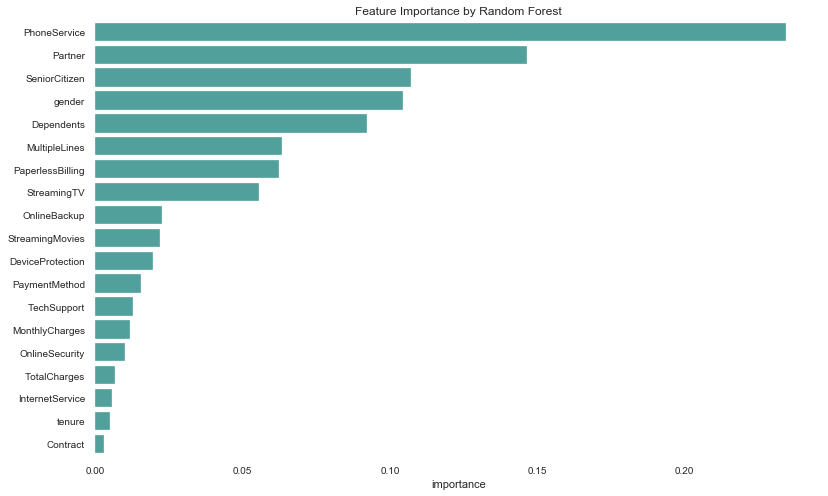

In [679]:
# Feature Importance
feature_names = data.drop(['Churn', 'customerID'], axis = 1).columns
feature_importance = pd.DataFrame({'importance': grid_rf.best_estimator_.feature_importances_}, index=feature_names).sort_values('importance')
sns.set_style("white")

plt.subplots(figsize=(13,8))
sns.barplot(x = feature_importance.importance.sort_values(ascending = False), y = feature_importance.index, palette = ['#45ADA8'])
plt.title('Feature Importance by Random Forest');

Still random forest seems to perform the best on the test set, we can see that there are no features with zero feature importance.

### 3.6 XGBoost <a id=xg>

In [697]:
xb_cl = xgb.XGBClassifier()

params_grid =  {
    'max_depth': [10,5, 15, 'none'],
    'learning_rate': [0.03, 0.1, 0.5, 1],
    'class_weight': ['balanced'],
    'random_state': [27, 901]
    
}

grid_xgb = GridSearchCV(xb_cl, cv = StratifiedKFold(5), param_grid = params_grid, n_jobs = -1, verbose = 10, 
                      scoring = 'f1').fit(X_train_prep, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 146 out of 160 | elapsed:   15.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   17.4s finished


In [698]:
#Best params
grid_xgb.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.03,
 'max_depth': 5,
 'random_state': 27}

In [699]:
y_test_pred = grid_xgb.best_estimator_.predict(X_test_prep)
y_train_pred = grid_xgb.best_estimator_.predict(X_train_prep)

print('Train performance on XGBoost:', f1_score(y_train_pred, y_train))
print('Test performance on XGBoost: %s \n'% f1_score(y_test, y_test_pred))
print('Precision: %s'% precision_score(y_test, y_test_pred))
print('Recall: %s'% recall_score(y_test, y_test_pred))

target_class = ['didn\'t churn', 'churn']
print('\n', classification_report(y_test, y_test_pred, target_names = target_class))
print('Confusion matrix, optimised for F1 score \n')
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=['pred_didn\'t churn', 'pred_churn'], index=['didn\'t churn', 'churn']))

Train performance on XGBoost: 0.6355140186915887
Test performance on XGBoost: 0.5868263473053892 

Precision: 0.6666666666666666
Recall: 0.5240641711229946

               precision    recall  f1-score   support

didn't churn       0.84      0.91      0.87      1035
       churn       0.67      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409

Confusion matrix, optimised for F1 score 

              pred_didn't churn  pred_churn
didn't churn                937          98
churn                       178         196


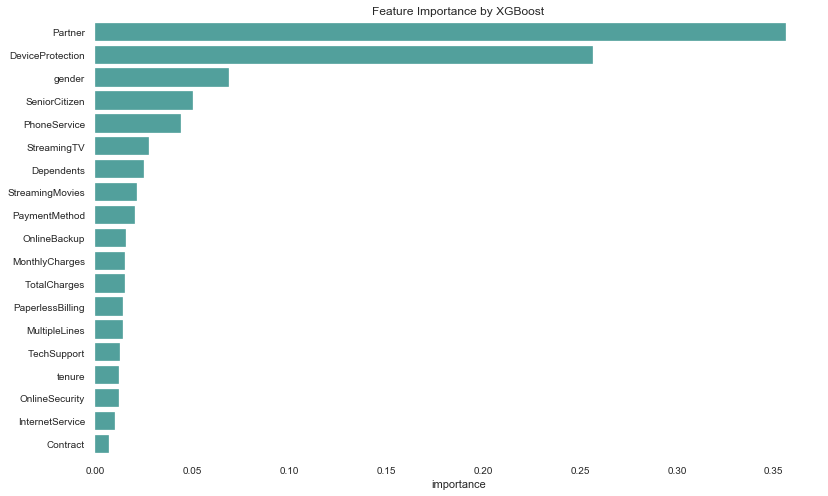

In [702]:
# Feature Importance
feature_names = data.drop(['Churn', 'customerID'], axis = 1).columns
feature_importance = pd.DataFrame({'importance': grid_xgb.best_estimator_.feature_importances_}, index=feature_names).sort_values('importance')
sns.set_style("white")

plt.subplots(figsize=(13,8))
sns.barplot(x = feature_importance.importance.sort_values(ascending = False), y = feature_importance.index, palette = ['#45ADA8'])
plt.title('Feature Importance by XGBoost');

In [700]:
# Predicted churn rate - now we are underestimating our churn rate
(98+196)/(937+178+98+196)

0.20865862313697658

## 4. Conclusions <a id=conc>

- The best model to predict would be Random Forest Classifier, it gives F1-score of 0.636, precision of 55% and recall of 76%.
- We should definitely look into the quality of our Fiber internet since it seems to be not on par, 85% of customers churn because of it;
- Gender, Streaming Services seem to not differentiate between churn and no churn;
- There seem to be a small number of customers who churn after a short period of time, they only use our Phone Services;